In [10]:
idun = False

In [11]:
import os
import torch
import json
import gc
import time

if idun:
    os.environ['HF_HOME'] = '/cluster/work/eliashk/models/'

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

device = 'cuda:0'
model_id = 'mistralai/Mistral-7B-Instruct-v0.2'
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [20]:
round(torch.cuda.get_device_properties(device).total_memory/(1024**2), 0)

12036.0

### Load test set and store domains, inputs and corresponding outputs

In [2]:
with open('shot_set_simple_domain.jsonl', 'r') as infile:
    shot_data = json.load(infile)

domains, inputs, outputs = [], [], []

for i in range(len(shot_data['shots'])):
    domains.append(shot_data['shots'][i]['domain'])
    inputs.append(shot_data['shots'][i]['input'])
    outputs.append(shot_data['shots'][i]['output'])

with open('test_set.jsonl', 'r') as infile:
    test_data = json.load(infile)

test_domains, commands, solutions, num_instances, num_predicates, num_goals = [], [], [], [], [], []

for i in range(len(test_data['tests'])):
    test_domains.append(test_data['tests'][i]['domain'])
    commands.append(test_data['tests'][i]['command'])
    solutions.append(test_data['tests'][i]['solution'])
    num_instances.append(test_data['tests'][i]['num_instances'])
    num_predicates.append(test_data['tests'][i]['num_predicates'])
    num_goals.append(test_data['tests'][i]['num_goals'])

### System prompt

In [3]:
system_prompt = 'You are a helpful PDDL assistant that will list up the available instances, predicates and goals for the given domain and natural language command. You can only answer in the desired format.'

### Create file for storing test data

In [21]:
results_file = 'mistral_results.txt'
if os.path.exists(results_file):
    os.remove(results_file)

device_name = torch.cuda.get_device_properties(device).name
device_capacity = round(torch.cuda.get_device_properties(device).total_memory/(1024**2), 0)

header =      "                      Mistral Large Language Model test                    \n"
underline =   "===========================================================================\n"
device_info =f"  Test completed on device {device_name} with {device_capacity} MB memory  \n" 


with open(results_file, 'a') as outfile:
    outfile.write(header)
    outfile.write(underline)
    outfile.write(device_info)
    outfile.write(underline)



### Mistral 7B 4-bit quantization

In [5]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

### System messages and lists for storing interesting test data

This test data is without prompt classification.

In [6]:
messages = [
        {'role': 'user', 'content': system_prompt},
        {'role': 'assistant', 'content': 'Please provide the domain.pddl and corresponding command.'},
        {'role': 'user', 'content': f'domain.pddl: {domains[0]}, command: {inputs[0]}'},
        {'role': 'assistant', 'content': 'Understood. What is the expected output format?'},
        {'role': 'user', 'content': f'### Expected output ### {outputs[0]}'},
    ]

allocated, model_input_size, inference_times, f1_scores, semantic_similarities, total_match_accuracies, model_outputs = [], [], [], [], [], [], []
instance_match_accuracies, predicate_match_accuracies, goal_match_accuracies = [], [], []

### Functions for computing metrics

In [7]:
def compute_accuracy(expected, generated):
    if expected == None:
        return 0.0
    else:
        return round(generated/expected, 2)

In [8]:
for i in range(len(shot_data['shots'])):
# # for i in range(8, 10):
    model_4bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config)
    memory_allocated_loaded = round(torch.cuda.memory_allocated(device)/(1024**2), 5)               # MB

    allocated.append(memory_allocated_loaded)

    number_of_examples = i+1
    test_set_number = 1
    number_of_max_new_tokens = 250  # default

    # if the loop has been executed at least once, remove the last two messages which is the ones that have to be last
    # the new messages to be added is another example from the shot_data
    if i>0:
        del messages[-2:]

        messages.append({'role': 'assistant', 'content': 'Please provide the domain.pddl and corresponding command.'})
        messages.append({'role': 'user', 'content': f'domain.pddl: {domains[i]}, command: {inputs[i]}'})
        messages.append({'role': 'assistant', 'content': 'Understood. What is the expected output format?'})
        messages.append({'role': 'user', 'content': f'### Expected output ### {outputs[i]}'})

    messages.append({'role': 'assistant', 'content': 'Thank you. Ready for the new instruction.'})
    messages.append({'role': 'user', 'content': f'domain.pddl: {test_domains[0]}, command: {commands[0]}'})
    
    # start timer
    start = torch.cuda.Event(enable_timing=True)
    start.record()

    # inference
    encodeds = tokenizer.apply_chat_template(messages, return_tensors='pt')
    model_inputs = encodeds.to(device)

    model_input_size.append(round((model_inputs.element_size()*model_inputs.nelement())/(1024**2), 5))    # MB
    
    with torch.no_grad():
        generated_ids = model_4bit.generate(
            model_inputs,
            pad_token_id=tokenizer.eos_token_id,
            max_new_tokens=number_of_max_new_tokens,
            do_sample=True,
        )
        
    decoded = tokenizer.batch_decode(generated_ids)

    end = torch.cuda.Event(enable_timing=True)
    end.record()
    
    torch.cuda.synchronize()

    # compute inference time
    timer = start.elapsed_time(end)/1000
    inference_times.append(timer)

    '''
    Format the output string - remove the last 4 characters which are the end token,
    then remove everything after the last delimiter and
    remove everything before the first occurence of "instance". Sometimes,
    the model outputs "Expected output:", so we delete everything before ":".
    Finally, remove newlines in output
    '''
    output_tokens = decoded[0]
    end_token = '[/INST]'

    end_tag_index = output_tokens.rfind(end_token)
    end_of_sentence = -4
    sliced_output = output_tokens[end_tag_index + len(end_token):end_of_sentence]

    delimiter = '|'
    last_delimiter = sliced_output.rfind(delimiter)
    model_output = sliced_output[:last_delimiter+1]

    # model_output = model_output[model_output.find('instance'):]
    # model_output = ' '.join(model_output.strip().split())

    # model_output = model_output[model_output.find(':')+1:]

    # remove newlines in output
    model_output = model_output.replace('\n', ' ')
    model_output = model_output.replace('\t', ' ')
    model_output = model_output.replace('\r', ' ')
    model_output = model_output.replace('  ', ' ')

    model_outputs.append(model_output)

    f1_score = None
    semantic_similarity = None


    # compute the accuracy of amount of instances, predicates and goals in the output
    # compared to the solution

    # count number of instances, predicates and goals in the model output
    num_instances_output = model_output.count('instance')
    num_predicates_output = model_output.count('predicate')
    num_goals_output = model_output.count('goal')

    # compare the number of instances, predicates and goals in the model output to the solution
    instance_match_accuracies.append(compute_accuracy(num_instances[0], num_instances_output))
    predicate_match_accuracies.append(compute_accuracy(num_predicates[0], num_predicates_output))
    goal_match_accuracies.append(compute_accuracy(num_goals[0], num_goals_output))

    #compute the average of the three accuracies
    total_match_accuracy = round((instance_match_accuracies[-1] + predicate_match_accuracies[-1] + goal_match_accuracies[-1])/3, 2)
    total_match_accuracies.append(total_match_accuracy)

    f1_scores.append(f1_score)
    semantic_similarities.append(semantic_similarity)

    # write the results to file
    result = {
        'Model': model_id + '-4bit',
        'Max new tokens': number_of_max_new_tokens,
        'Test set #': test_set_number,
        'Number of examples': number_of_examples,
        'F1Score': f1_scores[-1],
        'Semantic similarity': semantic_similarities[-1],
        'Instance match accuracy': instance_match_accuracies[-1],
        'Predicate match accuracy': predicate_match_accuracies[-1],
        'Goal match accuracy': goal_match_accuracies[-1],
        'Total match accuracy': total_match_accuracies[-1],
        'Inference time [s]': inference_times[-1],
        'GPU memory loaded [MB]': allocated[-1],
        'Model input size [MB]': model_input_size[-1],
        'Sliced output': model_outputs[-1],
        'Solution': solutions[0],
        'Simple': 'Yes',
    }

    with open(results_file, 'a') as outfile:
        for key, value in result.items():
            outfile.write(f'{key:<25}: {value}\n')
        outfile.write(underline)

    print(f'Mistral 7B instruct 4-bit finished on test {test_set_number} with {number_of_examples} examples.')

    # delete model to free up GPU memory
    del model_4bit
    del model_inputs
    del generated_ids
    torch.cuda.empty_cache()
    gc.collect()

    # wait for memory to reach <250 MB
    while torch.cuda.memory_allocated(device) > 250*(1024**2):
        time.sleep(0.1)

# clean up
torch.cuda.empty_cache()
gc.collect()

7
11
15
19
23
27
31
35
39
43


140

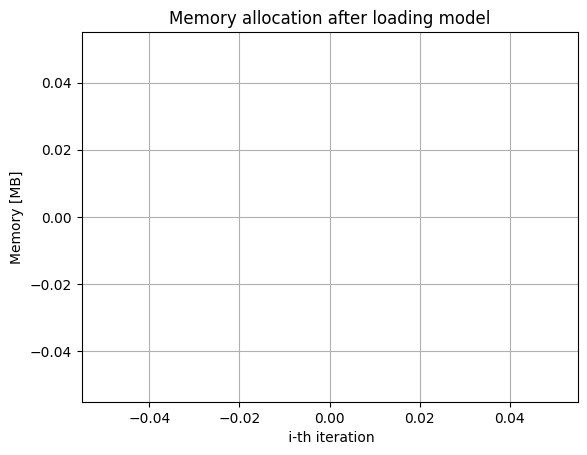

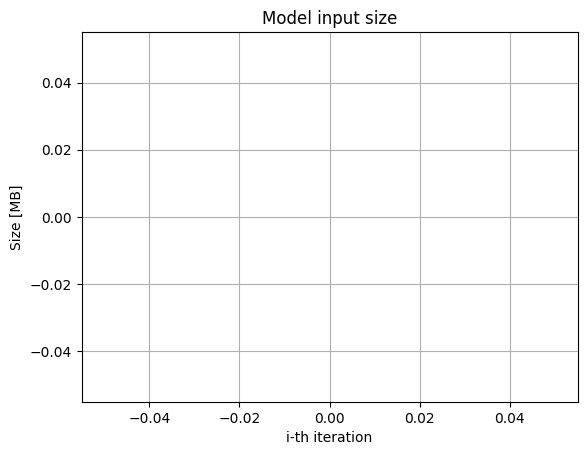

Allocated: []


In [9]:
# plot the allocated and reserverd memory for evey iteration
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, len(allocated)+1)
plt.plot(x, allocated)
plt.xlabel(' i-th iteration')
plt.ylabel('Memory [MB]')
plt.title('Memory allocation after loading model')
plt.grid()
plt.show()


x = np.arange(1, len(model_input_size)+1)
plt.plot(x, model_input_size)
plt.xlabel('i-th iteration')
plt.ylabel('Size [MB]')
plt.title('Model input size')
plt.grid()
plt.show()

# print all lists
print(f"Allocated: {allocated}")